In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 07 06:48 2019
Modified on Tue Nov 23 11:10 2021

@author: yuming
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from matplotlib import mlab
from astropy.io import fits
from astropy.coordinates import SkyCoord
from pathlib import Path

from dustmaps.config import config
config['data_dir'] = '/store/public/databases/dustmaps'

In [2]:
from dustmaps.planck import PlanckQuery

In [3]:
outpath = './output/'
Path(outpath).mkdir(exist_ok=True)

In [4]:
def _check_range(rng, allowed):
    if rng is None:
        rng = allowed
    else:
        if not hasattr(rng, '__len__'):
            raise ValueError("range object does not have len() method")

        if rng[0] < allowed[0] or rng[1] > allowed[1]:
            raise ValueError("lon_range should be within [%s,%s]" % allowed)
    return rng


def randsphere(num, ra_range=None, dec_range=None, system='eq'):
    """
    Generate random points on the sphere
    You can limit the range in ra and dec.  To generate on a spherical cap, see
    randcap()
    parameters
    ----------
    num: integer
        The number of randoms to generate
    ra_range: list, optional
        Should be within range [0,360].  Default [0,360]
    dec_range: list, optional
        Should be within range [-90,90].  Default [-90,90]
    system: string
        Default is 'eq' for the ra-dec system.  Can also be 'xyz'.
    output
    ------
        for system == 'eq' the return is a tuple
            ra,dec = randsphere(...)
        for system == 'xyz' the return is a tuple
            x,y,z = randsphere(...)
    examples
    --------
        ra,dec = randsphere(2000, ra_range=[10,35], dec_range=[-25,15])
        x,y,z = randsphere(2000, system='xyz')
    """

    ra_range = _check_range(ra_range, [0.0, 360.0])
    dec_range = _check_range(dec_range, [-90.0, 90.0])

    ra = np.random.random(num)  # 0-1之间的随机数array
    ra *= (ra_range[1] - ra_range[0])
    if ra_range[0] > 0:
        ra += ra_range[0]

    # number [-1,1)
    cosdec_min = np.cos(np.deg2rad(90.0 + dec_range[0]))
    cosdec_max = np.cos(np.deg2rad(90.0 + dec_range[1]))
    v = np.random.random(num)
    v *= (cosdec_max - cosdec_min)
    v += cosdec_min

    np.clip(v, -1.0, 1.0, v)
    # Now this generates on [0,pi)
    dec = np.arccos(v)
    # convert to degrees
    # rad2deg(dec,dec)
    dec = np.rad2deg(dec)
    # now in range [-90,90.0)
    dec -= 90.0

    c1 = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')
    c2 = SkyCoord(l=ra * u.degree, b=dec * u.degree, frame='galactic')
    # if system == 'xyz':
    #     # x,y,z = eq2xyz(ra, dec)
    #     # return x,y,z
    #     return ra, dec
    # else:
    #     return ra, dec
#    return ra, dec
    if system == 'gal':
        return c2
    else:
        return c1

# Check columns

In [5]:
tb = Table.read("refined_gdr3qsoc_20230115_v1_new_ULAS.fits",character_as_bytes=False)
tb

source_id,ra,dec,redshift_qsoc,gr,ri,iz,zy,gw1,rw1,iw1,zw1,yw1,w12,bp_rp,bp_g,g_rp,bp_rp_ef,norm_pmra,norm_pmdec,norm_plx,fpm0,log_fpm0,AEN,AEN_sig,pred_class,p_qso,p_star,redshift_nn,solution_id,astrometric_selection_flag,gaia_crf_source,vari_best_class_name,vari_best_class_score,fractional_variability_g,structure_function_index,structure_function_index_scatter,qso_variability,non_qso_variability,vari_agn_membership_score,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classlabel_dsc,classlabel_dsc_joint,classlabel_oa,redshift_qsoc_lower,redshift_qsoc_upper,ccfratio_qsoc,zscore_qsoc,flags_qsoc,n_transits,intensity_quasar,intensity_quasar_error,intensity_hostgalaxy,intensity_hostgalaxy_error,radius_hostgalaxy,radius_hostgalaxy_error,sersic_index,sersic_index_error,ellipticity_hostgalaxy,ellipticity_hostgalaxy_error,posangle_hostgalaxy,posangle_hostgalaxy_error,host_galaxy_detected,l2_norm,morph_params_corr_vec [15],host_galaxy_flag,source_selection_flags,source_id_2,l,b,parallax,parallax_error,pm,pmra,pmra_error,pmdec,pmdec_error,pmra_pmdec_corr,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,pseudocolour,pseudocolour_error,ruwe,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_bp_mean_mag,phot_bp_rp_excess_factor,phot_rp_mean_mag,phot_g_mean_mag,in_qso_candidates,non_single_star,in_galaxy_candidates,in_andromeda_survey,ps_obj_id,ra_ps,dec_ps,ps_epoch_mean,g_mean_psf_mag,g_mean_psf_mag_error,r_mean_psf_mag,r_mean_psf_mag_error,i_mean_psf_mag,i_mean_psf_mag_error,z_mean_psf_mag,z_mean_psf_mag_error,y_mean_psf_mag,y_mean_psf_mag_error,ps_n_detections,number_of_mates,angular_distance,clean_panstarrs1_oid,number_of_neighbours,objID,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,Name,e_RAdeg,e_DEdeg,ePos,nW1,mW1,nW2,mW2,MJD,RAPMdeg,DEPMdeg,e_RAPMdeg,e_DEPMdeg,ePosPM,pmRA_x,pmDE,e_pmRA,e_pmDE,snrW1pm,snrW2pm,FW1pm,e_FW1pm,FW2pm,e_FW2pm,W1mproPM,e_W1mproPM,W2mproPM,e_W2mproPM,pmQual,Dist,chi2pmRA,chi2pmDE,ka,k1,k2,km,plx1,e_plx1,plx2,e_plx2,Sep,ccf,abfl,angDist,Separation,JName,ra_x,dec_x,yAperMag3,j_1AperMag3,hAperMag3,kAperMag3,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,sourceID,mode,epoch,mergedClass,angDist_x
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,'electron'.s**-1,'electron'.s**-1,'electron'.s**-1,'electron'.s**-1,mas,mas,,,,,deg,deg,,,,,,,deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,mas,,,1 / um,1 / um,,,,,mag,,mag,mag,,,,,,deg,deg,d,,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,arcsec,,,,deg,deg,arcsec,arcsec,deg,,arcsec,arcsec,arcsec,,,,,MJD,deg,deg,arcsec,arcsec,arcsec,arcsec / yr,arcsec / yr,arcsec / yr,arcsec / yr,,,,,,,mag,mag,mag,mag,,arcsec,,,,,,,arcsec,arcsec,arcsec,arcsec,arcsec,,,arcsec,arcsec,,deg,deg,mag,mag,mag,mag,mag,mag,mag,mag,,,,,arcsec
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,bool,bool,str26,float32,float32,float32,float64,float32,float32,float64,float32,float32,str14,str12,str11,float32,float32,float32,float32,int64,int32,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,bool,float64,float64,int16,int32,int64,float64,float64,float64,float32,float32,float64,float32,float64,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,bool,bool,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16,float32,int64,int16,str18,float64,float64,float32,float32,float32,str20,float32,float32,float32,int16,int16,int16,int16,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,float32,float32,float32,str1,str1,str1,str1,float32,float

In [6]:
tb.columns

<TableColumns names=('source_id','ra','dec','redshift_qsoc','gr','ri','iz','zy','gw1','rw1','iw1','zw1','yw1','w12','bp_rp','bp_g','g_rp','bp_rp_ef','norm_pmra','norm_pmdec','norm_plx','fpm0','log_fpm0','AEN','AEN_sig','pred_class','p_qso','p_star','redshift_nn','solution_id','astrometric_selection_flag','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','structure_function_index','structure_function_index_scatter','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','ccfratio_qsoc','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','sersic_index','sersic_index_error','ellipticity_hostgalaxy','ellipticity_hostgalaxy_error','posangle_hostgalaxy

### 保留哪些columns？
'source_id','ra','dec','redshift_qsoc',
'snrW1pm','snrW2pm','W1mproPM','W2mproPM',
'g_mean_psf_mag','r_mean_psf_mag','i_mean_psf_mag','z_mean_psf_mag','y_mean_psf_mag',
'g_mean_psf_mag_error','r_mean_psf_mag_error','i_mean_psf_mag_error','z_mean_psf_mag_error','y_mean_psf_mag_error',
'yAperMag3','j_1AperMag3','hAperMag3','kAperMag3',
'yAperMag3Err','j_1AperMag3Err','hAperMag3Err','kAperMag3Err',
'pmRA_x','pmDE','e_pmRA','e_pmDE'
### 没找到iKron和zKron

In [7]:
tb_select = tb[['source_id','ra','dec','redshift_qsoc',
'snrW1pm','snrW2pm','W1mproPM','W2mproPM',
'g_mean_psf_mag','r_mean_psf_mag','i_mean_psf_mag','z_mean_psf_mag','y_mean_psf_mag',
'g_mean_psf_mag_error','r_mean_psf_mag_error','i_mean_psf_mag_error','z_mean_psf_mag_error','y_mean_psf_mag_error',
'yAperMag3','j_1AperMag3','hAperMag3','kAperMag3',
'yAperMag3Err','j_1AperMag3Err','hAperMag3Err','kAperMag3Err',
'pmRA_x','pmDE','e_pmRA','e_pmDE']]

In [8]:
df = tb_select.to_pandas()

In [9]:
# 添加l,b两个columns

coord = SkyCoord(ra=df.ra.values*u.deg,
                 dec=df.dec.values*u.deg,
                 frame='icrs')

df['l'] = coord.galactic.l.deg
df['b'] = coord.galactic.b.deg

In [10]:
df

,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,W1mproPM,W2mproPM,g_mean_psf_mag,r_mean_psf_mag,...,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,pmRA_x,pmDE,e_pmRA,e_pmDE,l,b
0,2767321680207884800,0.005043,13.303750,1.773578,48.099998,58.799999,15.625000,14.462000,19.437099,19.220200,...,0.033,0.044,NaN,0.072,0.02291,-0.02118,0.0162,0.0160,104.171599,-47.686308
1,2765772777561947520,0.010899,11.978308,2.605525,15.600000,14.000000,17.440001,16.209000,20.990999,20.710100,...,0.106,0.159,0.225,0.248,-0.01513,0.13865,0.0708,0.0697,103.586317,-48.953346
2,2740011460641576192,0.011553,3.421437,0.565801,54.000000,48.799999,15.319000,14.589000,20.939199,20.254700,...,0.050,0.047,0.046,0.035,0.00426,0.00464,0.0155,0.0153,98.860924,-57.029027
3,2740013011126020864,0.012070,3.429246,0.792390,43.299999,48.900002,13.740000,12.695000,19.964100,19.133801,...,0.023,0.022,0.018,0.012,0.00796,-0.01146,0.0057,0.0056,98.867025,-57.021940
4,2772105036825154944,0.019762,15.645914,0.614334,28.200001,24.100000,16.601000,15.567000,20.665600,20.489500,...,0.186,0.159,0.182,0.145,-0.06491,0.02853,0.0398,0.0374,105.172611,-45.447429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101582,2738642259426916608,359.981289,1.627872,3.044864,37.599998,30.400000,16.096001,15.158000,20.560400,20.162399,...,0.080,0.101,0.147,0.140,0.01826,0.01692,0.0280,0.0282,97.552001,-58.682235
101583,2746745076010406400,359.995799,7.962619,4.509255,61.700001,64.400002,14.972000,14.099000,20.877800,20.293900,...,0.098,0.110,0.080,0.065,0.00659,0.00642,0.0116,0.0111,101.563987,-52.761191
101584,2765244805821809792,359.996633,10.129151,0.659087,70.500000,100.400002,14.182000,13.014000,18.449900,18.438700,...,0.023,0.030,0.034,0.022,-0.00295,-0.00947,0.0067,0.0064,102.685227,-50.708875
101585,2766932526107620352,359.997679,12.545537,3.065764,19.799999,12.200000,17.073000,16.368999,20.595100,20.509600,...,0.115,0.156,NaN,0.195,0.08854,0.03764,0.0641,0.0625,103.825309,-48.408354


In [11]:
# select good subsets
df_good = df.query("snrW1pm > 5 and snrW2pm > 5\
and W1mproPM > 8 and W2mproPM > 7\
and i_mean_psf_mag >= 14\
and z_mean_psf_mag > 0\
and y_mean_psf_mag > 0\
and j_1AperMag3Err < 0.2171\
and hAperMag3Err < 0.2171\
and kAperMag3Err < 0.2171\
and i_mean_psf_mag_error < 0.2171\")

## 查看jhk的星等探测的error分布

In [44]:
import seaborn as sns

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-pack

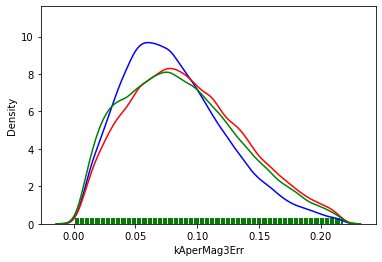

In [54]:
plt.figure()
sns.distplot(df_good.j_1AperMag3Err,hist=False, rug=True,color = 'b')
sns.distplot(df_good.hAperMag3Err,hist=False, rug=True,color='r')
sns.distplot(df_good.kAperMag3Err,hist=False, rug=True,color='g')
plt.show()

<AxesSubplot:>

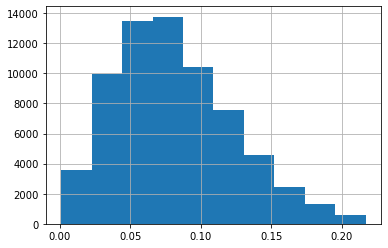

In [40]:
df_good.j_1AperMag3Err.hist()

<AxesSubplot:>

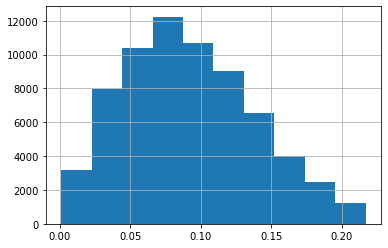

In [41]:
df_good.hAperMag3Err.hist()

<AxesSubplot:>

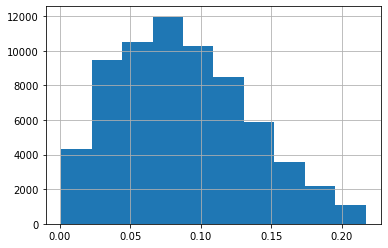

In [43]:
df_good.kAperMag3Err.hist()

In [ ]:
## 选择j band来进行模拟源筛优即可

In [12]:
df1_good = df_good.rename(columns={'g_mean_psf_mag':'gp','r_mean_psf_mag':'rp','i_mean_psf_mag':'ip',
                                   'z_mean_psf_mag':'zp','y_mean_psf_mag':'yp',
                         'yAperMag3':'yap','j_1AperMag3':'jap','hAperMag3':'hap','kAperMag3':'kap',
                        'W1mproPM':'w1vega','W2mproPM':'w2vega'},inplace=False)

In [13]:
# 做vega-ab转换
df1_good.eval('w1ab=w1vega+2.699',inplace=True)
df1_good.eval('w2ab=w2vega+3.339',inplace=True)
df1_good.eval('yab=yap+0.634',inplace=True)
df1_good.eval('jab=jap+0.938',inplace=True)
df1_good.eval('hab=hap+1.379',inplace=True)
df1_good.eval('kab=kap+1.900',inplace=True)

In [14]:
df1_good.columns

Index(['source_id', 'ra', 'dec', 'redshift_qsoc', 'snrW1pm', 'snrW2pm',
       'w1vega', 'w2vega', 'gp', 'rp', 'ip', 'zp', 'yp',
       'g_mean_psf_mag_error', 'r_mean_psf_mag_error', 'i_mean_psf_mag_error',
       'z_mean_psf_mag_error', 'y_mean_psf_mag_error', 'yap', 'jap', 'hap',
       'kap', 'yAperMag3Err', 'j_1AperMag3Err', 'hAperMag3Err', 'kAperMag3Err',
       'pmRA_x', 'pmDE', 'e_pmRA', 'e_pmDE', 'l', 'b', 'w1ab', 'w2ab', 'yab',
       'jab', 'hab', 'kab'],
      dtype='object')

In [15]:
df1_good.reset_index(inplace=True)

In [16]:
df1_good

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,e_pmRA,e_pmDE,l,b,w1ab,w2ab,yab,jab,hab,kab
0,2,2740011460641576192,0.011553,3.421437,0.565801,54.000000,48.799999,15.319000,14.589000,20.939199,...,0.0155,0.0153,98.860924,-57.029027,18.018000,17.927999,19.312000,18.997000,18.632999,18.312000
1,3,2740013011126020864,0.012070,3.429246,0.792390,43.299999,48.900002,13.740000,12.695000,19.964100,...,0.0057,0.0056,98.867025,-57.021940,16.438999,16.034000,18.386002,18.105999,17.580000,17.048000
2,4,2772105036825154944,0.019762,15.645914,0.614334,28.200001,24.100000,16.601000,15.567000,20.665600,...,0.0398,0.0374,105.172611,-45.447429,19.299999,18.906000,20.536001,20.070000,19.968000,19.740999
3,5,2768962873110894208,0.024049,14.457742,1.611916,14.700000,14.900000,17.393000,16.058001,20.149099,...,0.0688,0.0684,104.691046,-46.587583,20.091999,19.397001,20.172001,20.011999,19.792000,20.035000
4,8,2765244977620763776,0.036200,10.167059,1.103319,40.900002,37.400002,15.941000,15.004000,20.753700,...,0.0226,0.0220,102.762331,-50.685027,18.639999,18.343000,20.183001,20.129999,19.808001,19.395000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,101581,2772389088781683072,359.971924,15.787100,0.265005,81.900002,128.699997,12.833000,11.802000,18.741301,...,0.0045,0.0042,105.166407,-45.298987,15.532000,15.141000,17.816000,17.586000,17.105000,16.437000
67721,101582,2738642259426916608,359.981289,1.627872,3.044864,37.599998,30.400000,16.096001,15.158000,20.560400,...,0.0280,0.0282,97.552001,-58.682235,18.795000,18.497000,19.956001,19.948000,19.993000,19.900999
67722,101583,2746745076010406400,359.995799,7.962619,4.509255,61.700001,64.400002,14.972000,14.099000,20.877800,...,0.0116,0.0111,101.563987,-52.761191,17.671000,17.438000,20.060001,19.744999,18.906000,18.570999
67723,101584,2765244805821809792,359.996633,10.129151,0.659087,70.500000,100.400002,14.182000,13.014000,18.449900,...,0.0067,0.0064,102.685227,-50.708875,16.881001,16.353001,18.438002,18.472000,18.166000,17.724001


# Mocking

In [17]:
## 保留原来高银纬处的数据
df1_good.eval('o_ra=ra', inplace=True)
df1_good.eval('o_dec=dec', inplace=True)
df1_good.eval('o_l=l', inplace=True)
df1_good.eval('o_b=b', inplace=True)
df1_good.eval('o_g=gp', inplace=True)
df1_good.eval('o_r=rp', inplace=True)
df1_good.eval('o_i=ip', inplace=True)
df1_good.eval('o_z=zp', inplace=True)
df1_good.eval('o_y=yp', inplace=True)
### Also for UKIDSS bands
df1_good.eval('o_yap=yap',inplace=True)
df1_good.eval('o_jap=jap',inplace=True)
df1_good.eval('o_hap=hap',inplace=True)
df1_good.eval('o_kap=kap',inplace=True)
df1_good.eval('o_jab=jab',inplace=True)
df1_good.eval('o_hab=hab',inplace=True)
df1_good.eval('o_kab=kab',inplace=True)
### For Catwise2020
df1_good.eval('o_w1vega=w1vega', inplace=True)
df1_good.eval('o_w2vega=w2vega', inplace=True)
df1_good.eval('o_w1ab=w1ab', inplace=True)
df1_good.eval('o_w2ab=w2ab', inplace=True)

c_ori = SkyCoord(ra=df1_good['o_ra'].values * u.degree,
                 dec=df1_good['o_dec'].values * u.degree, frame='icrs')
planck = PlanckQuery()
df1_good['o_ebv'] = planck(c_ori)  # 原来位置的色余

In [18]:
df1_good

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,o_hap,o_kap,o_jab,o_hab,o_kab,o_w1vega,o_w2vega,o_w1ab,o_w2ab,o_ebv
0,2,2740011460641576192,0.011553,3.421437,0.565801,54.000000,48.799999,15.319000,14.589000,20.939199,...,17.254000,16.412001,18.997000,18.632999,18.312000,15.319000,14.589000,18.018000,17.927999,0.034832
1,3,2740013011126020864,0.012070,3.429246,0.792390,43.299999,48.900002,13.740000,12.695000,19.964100,...,16.201000,15.148000,18.105999,17.580000,17.048000,13.740000,12.695000,16.438999,16.034000,0.034832
2,4,2772105036825154944,0.019762,15.645914,0.614334,28.200001,24.100000,16.601000,15.567000,20.665600,...,18.589001,17.841000,20.070000,19.968000,19.740999,16.601000,15.567000,19.299999,18.906000,0.063765
3,5,2768962873110894208,0.024049,14.457742,1.611916,14.700000,14.900000,17.393000,16.058001,20.149099,...,18.413000,18.135000,20.011999,19.792000,20.035000,17.393000,16.058001,20.091999,19.397001,0.048878
4,8,2765244977620763776,0.036200,10.167059,1.103319,40.900002,37.400002,15.941000,15.004000,20.753700,...,18.429001,17.495001,20.129999,19.808001,19.395000,15.941000,15.004000,18.639999,18.343000,0.081471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,101581,2772389088781683072,359.971924,15.787100,0.265005,81.900002,128.699997,12.833000,11.802000,18.741301,...,15.726000,14.537000,17.586000,17.105000,16.437000,12.833000,11.802000,15.532000,15.141000,0.057705
67721,101582,2738642259426916608,359.981289,1.627872,3.044864,37.599998,30.400000,16.096001,15.158000,20.560400,...,18.614000,18.000999,19.948000,19.993000,19.900999,16.096001,15.158000,18.795000,18.497000,0.032891
67722,101583,2746745076010406400,359.995799,7.962619,4.509255,61.700001,64.400002,14.972000,14.099000,20.877800,...,17.527000,16.671000,19.744999,18.906000,18.570999,14.972000,14.099000,17.671000,17.438000,0.060413
67723,101584,2765244805821809792,359.996633,10.129151,0.659087,70.500000,100.400002,14.182000,13.014000,18.449900,...,16.787001,15.824000,18.472000,18.166000,17.724001,14.182000,13.014000,16.881001,16.353001,0.088134


In [19]:
# 消光系数的文件要update么(先不update以便和之前做比较)
ectb = pd.read_csv('extcoefUKIDSS.csv', index_col=0)

ec = ectb['rb']  # 消光系数
bands = ['gp', 'rp', 'ip', 'zp', 'yp',
         'yap', 'jap', 'hap','kap','yab','jab','hab','kab',
         'w1vega', 'w2vega', 'w1ab','w2ab']

for b in bands:  # 减去原来的位置处的消光后的星等
    db = 'd' + b
    if b[0] == 'g' or  b[0] == 'r' or b[0] == 'i' or b[0] == 'z' or b[0] == 'y' :
        df1_good[db] = df1_good[b] - df1_good['o_ebv'] * ec[b[0]]  
    if b[0] == 'j' or  b[0] == 'h' or  b[0] == 'k':
        df1_good[db] = df1_good[b] - df1_good['o_ebv'] * ec[b[0].upper()]                                        
    if b[0] == 'w':
        df1_good[db] = df1_good[b] - df1_good['o_ebv'] * ec[b[0].upper()+b[1]]

In [20]:
ec

g     3.5805
r     2.6133
i     1.9468
z     1.5097
y     1.2245
J     0.7285
H     0.4185
K     0.2263
W1    0.1209
W2    0.0806
Name: rb, dtype: float64

In [21]:
df1_good

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,dhap,dkap,dyab,djab,dhab,dkab,dw1vega,dw2vega,dw1ab,dw2ab
0,2,2740011460641576192,0.011553,3.421437,0.565801,54.000000,48.799999,15.319000,14.589000,20.939199,...,17.239423,16.404118,19.269349,18.971625,18.618422,18.304118,15.314789,14.586192,18.013788,17.925192
1,3,2740013011126020864,0.012070,3.429246,0.792390,43.299999,48.900002,13.740000,12.695000,19.964100,...,16.186423,15.140117,18.343350,18.080624,17.565423,17.040118,13.735789,12.692192,16.434788,16.031193
2,4,2772105036825154944,0.019762,15.645914,0.614334,28.200001,24.100000,16.601000,15.567000,20.665600,...,18.562315,17.826570,20.457921,20.023547,19.941315,19.726569,16.593291,15.561861,19.292290,18.900861
3,5,2768962873110894208,0.024049,14.457742,1.611916,14.700000,14.900000,17.393000,16.058001,20.149099,...,18.392545,18.123939,20.112150,19.976392,19.771544,20.023939,17.387090,16.054061,20.086090,19.393062
4,8,2765244977620763776,0.036200,10.167059,1.103319,40.900002,37.400002,15.941000,15.004000,20.753700,...,18.394905,17.476564,20.083239,20.070648,19.773905,19.376564,15.931150,14.997433,18.630150,18.336434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,101581,2772389088781683072,359.971924,15.787100,0.265005,81.900002,128.699997,12.833000,11.802000,18.741301,...,15.701850,14.523941,17.745340,17.543962,17.080850,16.423942,12.826024,11.797349,15.525023,15.136349
67721,101582,2738642259426916608,359.981289,1.627872,3.044864,37.599998,30.400000,16.096001,15.158000,20.560400,...,18.600236,17.993556,19.915727,19.924039,19.979235,19.893556,16.092024,15.155349,18.791024,18.494349
67722,101583,2746745076010406400,359.995799,7.962619,4.509255,61.700001,64.400002,14.972000,14.099000,20.877800,...,17.501718,16.657328,19.986026,19.700988,18.880717,18.557328,14.964696,14.094131,17.663696,17.433130
67723,101584,2765244805821809792,359.996633,10.129151,0.659087,70.500000,100.400002,14.182000,13.014000,18.449900,...,16.750117,15.804056,18.330081,18.407794,18.129116,17.704056,14.171345,13.006896,16.870345,16.345897


In [22]:
df11 = df1_good.copy()
df22 = df1_good.copy()

## Generate NIR Mock Samples

## Round 1: seed=1

In [23]:
np.random.seed(1)

In [24]:
c = randsphere(len(df11), [0.0, 360.0], [-5,5], system='gal')
ceq = c.transform_to('icrs')
ebv = planck(ceq)  
data1 = {'ebv': ebv}
ebv = pd.DataFrame(data1)

In [25]:
ebv                                   
#ebv.to_csv(outpath + 'ebv_mockqall.csv')

,ebv
0,0.761140
1,2.107201
2,2.429929
3,0.731554
4,0.970654
...,...
67720,0.588766
67721,1.136958
67722,0.452149
67723,5.328740


(array([11819., 20239., 10885.,  6447.,  3735.,  2451.,  1721.,  1325.,
          990.,   782.,   690.,   542.,   462.,   427.,   380.,   351.,
          310.,   217.,   221.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <BarContainer object of 19 artists>)

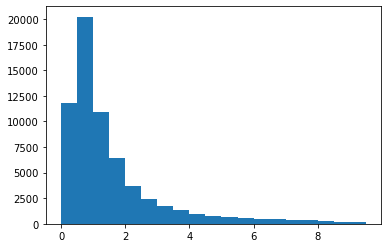

In [26]:
plt.hist(ebv,bins=np.arange(0.0,10.0,0.5))

In [27]:
df11['ra'] = ceq.ra.deg
df11['dec'] = ceq.dec.deg
df11['l'] = c.l.deg
df11['b'] = c.b.deg

df11['ebv'] = ebv # 问题在这里，应该是index的问题

for b in bands:  # 加上指定位置处的消光后的星等
    db = 'd' + b
    if b[0] == 'g' or  b[0] == 'r' or b[0] == 'i' or b[0] == 'z' or b[0] == 'y' :
        df11[b] = df11[db] + df11['ebv'] * ec[b[0]]  
    if b[0] == 'j' or  b[0] == 'h' or  b[0] == 'k':
        df11[b] = df11[db] + df11['ebv'] * ec[b[0].upper()]                                        
    if b[0] == 'w':
        df11[b] = df11[db] + df11['ebv'] * ec[b[0].upper()+b[1]]

df11

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,dkap,dyab,djab,dhab,dkab,dw1vega,dw2vega,dw1ab,dw2ab,ebv
0,2,2740011460641576192,56.584367,48.772173,0.565801,54.000000,48.799999,15.406811,14.647540,23.539747,...,16.404118,19.269349,18.971625,18.618422,18.304118,15.314789,14.586192,18.013788,17.925192,0.761140
1,3,2740013011126020864,129.149247,-39.705601,0.792390,43.299999,48.900002,13.990549,12.862033,27.384218,...,15.140117,18.343350,18.080624,17.565423,17.040118,13.735789,12.692192,16.434788,16.031193,2.107201
2,4,2772105036825154944,269.673512,-30.566440,0.614334,28.200001,24.100000,16.887069,15.757713,29.137651,...,17.826570,20.457921,20.023547,19.941315,19.726569,16.593291,15.561861,19.292290,18.900861,2.429929
3,5,2768962873110894208,346.720444,56.518488,1.611916,14.700000,14.900000,17.475535,16.113024,22.593422,...,18.123939,20.112150,19.976392,19.771544,20.023939,17.387090,16.054061,20.086090,19.393062,0.731554
4,8,2765244977620763776,288.610587,19.461234,1.103319,40.900002,37.400002,16.048502,15.075668,23.937421,...,17.476564,20.083239,20.070648,19.773905,19.376564,15.931150,14.997433,18.630150,18.336434,0.970654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,101581,2772389088781683072,284.577695,-6.978293,0.265005,81.900002,128.699997,12.897205,11.844803,20.642762,...,14.523941,17.745340,17.543962,17.080850,16.423942,12.826024,11.797349,15.525023,15.136349,0.588766
67721,101582,2738642259426916608,5.418685,60.466918,3.044864,37.599998,30.400000,16.229482,15.246988,24.513512,...,17.993556,19.915727,19.924039,19.979235,19.893556,16.092024,15.155349,18.791024,18.494349,1.136958
67722,101583,2746745076010406400,104.438693,-13.688034,4.509255,61.700001,64.400002,15.019361,14.130574,22.280414,...,16.657328,19.986026,19.700988,18.880717,18.557328,14.964696,14.094131,17.663696,17.433130,0.452149
67723,101584,2765244805821809792,246.023568,-51.627804,0.659087,70.500000,100.400002,14.815589,13.436393,37.213889,...,15.804056,18.330081,18.407794,18.129116,17.704056,14.171345,13.006896,16.870345,16.345897,5.328740


In [58]:
#df11_good = df11.query("ip <= 23.1\
#    and zp <= 22.3\
 #   and yp <= 21.3\
  #  and jap<= 19.9\
   # and hap<= 19.0\
    #and kap<= 18.8")

df11_good = df11.query("ip <= 23.1\
    and zp <= 22.3\
    and yp <= 21.3\
    and jap<= 19.9")
df11_good

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,dkap,dyab,djab,dhab,dkab,dw1vega,dw2vega,dw1ab,dw2ab,ebv
0,2,2740011460641576192,56.584367,48.772173,0.565801,54.000000,48.799999,15.406811,14.647540,23.539747,...,16.404118,19.269349,18.971625,18.618422,18.304118,15.314789,14.586192,18.013788,17.925192,0.761140
1,3,2740013011126020864,129.149247,-39.705601,0.792390,43.299999,48.900002,13.990549,12.862033,27.384218,...,15.140117,18.343350,18.080624,17.565423,17.040118,13.735789,12.692192,16.434788,16.031193,2.107201
3,5,2768962873110894208,346.720444,56.518488,1.611916,14.700000,14.900000,17.475535,16.113024,22.593422,...,18.123939,20.112150,19.976392,19.771544,20.023939,17.387090,16.054061,20.086090,19.393062,0.731554
4,8,2765244977620763776,288.610587,19.461234,1.103319,40.900002,37.400002,16.048502,15.075668,23.937421,...,17.476564,20.083239,20.070648,19.773905,19.376564,15.931150,14.997433,18.630150,18.336434,0.970654
7,14,2772071707879157632,16.532019,66.441485,1.937504,40.900002,39.900002,16.143607,14.986405,23.036452,...,16.940504,19.251205,19.108210,19.213589,18.840503,16.029392,14.910261,18.728392,18.249262,0.944708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67717,101578,2772394723778797312,319.715759,55.976539,NaN,35.299999,31.000000,16.483151,15.389101,24.901451,...,17.600385,19.772737,19.755387,19.444670,19.500385,16.341260,15.294506,19.040259,18.633507,1.173624
67719,101580,2738631333029907200,194.913924,-57.857820,NaN,56.400002,76.300003,15.277503,13.873669,24.144334,...,16.777994,19.459092,19.552445,19.056044,18.677993,15.187257,13.813505,17.886256,17.152505,0.746455
67720,101581,2772389088781683072,284.577695,-6.978293,0.265005,81.900002,128.699997,12.897205,11.844803,20.642762,...,14.523941,17.745340,17.543962,17.080850,16.423942,12.826024,11.797349,15.525023,15.136349,0.588766
67721,101582,2738642259426916608,5.418685,60.466918,3.044864,37.599998,30.400000,16.229482,15.246988,24.513512,...,17.993556,19.915727,19.924039,19.979235,19.893556,16.092024,15.155349,18.791024,18.494349,1.136958


In [59]:
df11_good.to_csv(outpath+'MockGPQNIR_1.csv', index=False)

(array([5775., 4872., 3522., 2764., 2476., 2476., 2794., 3522., 4360.,
        5290.]),
 array([-4.99985018e+00, -3.99990022e+00, -2.99995027e+00, -2.00000031e+00,
        -1.00005035e+00, -1.00393302e-04,  9.99849564e-01,  1.99979952e+00,
         2.99974948e+00,  3.99969944e+00,  4.99964939e+00]),
 <BarContainer object of 10 artists>)

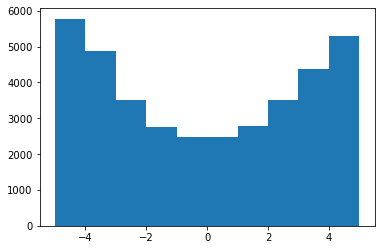

In [30]:
plt.hist(df11_good.b) # 已解决（问题出在reset_index上）

## 关于未使用reset_index导致模拟源天区分布中间无留白的问题
对df进行good筛选后，如果不reset_index，后续df11['ebv']=ebv时，ebv的值是按照df11中index对应的位置填写进去的，也就是说ebv中index=2的值本来应该填在df11的第三行，但由于df11的第一行的index就是2，所以该值填入了df11的第一行。df11的index最大到十万多而ebv的index最大只到67724，所以df11中出现很多缺失值。受ebv的影响，各mag columns也出现了相应缺失值。  


## Round 2: seed=2

In [31]:
np.random.seed(2)

In [32]:
c = randsphere(len(df22), [0.0, 360.0], [-5,5], system='gal')
ceq = c.transform_to('icrs')
ebv = planck(ceq)  
data2 = {'ebv': ebv}
ebv = pd.DataFrame(data2)

In [33]:
ebv                                   
#ebv.to_csv(outpath + 'ebv_mockqall.csv')

,ebv
0,0.824591
1,16.729013
2,0.435854
3,0.469403
4,1.022119
...,...
67720,1.524263
67721,10.462111
67722,16.853025
67723,0.613095


In [34]:
df22['ra'] = ceq.ra.deg
df22['dec'] = ceq.dec.deg
df22['l'] = c.l.deg
df22['b'] = c.b.deg

df22['ebv'] = ebv

for b in bands:  # 加上指定位置处的消光后的星等
    db = 'd' + b
    if b[0] == 'g' or  b[0] == 'r' or b[0] == 'i' or b[0] == 'z' or b[0] == 'y' :
        df22[b] = df22[db] + df22['ebv'] * ec[b[0]]  
    if b[0] == 'j' or  b[0] == 'h' or  b[0] == 'k':
        df22[b] = df22[db] + df22['ebv'] * ec[b[0].upper()]                                        
    if b[0] == 'w':
        df22[b] = df22[db] + df22['ebv'] * ec[b[0].upper()+b[1]]
        
df22

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,dkap,dyab,djab,dhab,dkab,dw1vega,dw2vega,dw1ab,dw2ab,ebv
0,2,2740011460641576192,69.556746,47.973403,0.565801,54.000000,48.799999,15.414482,14.652654,23.766934,...,16.404118,19.269349,18.971625,18.618422,18.304118,15.314789,14.586192,18.013788,17.925192,0.824591
1,3,2740013011126020864,271.306202,-20.721631,0.792390,43.299999,48.900002,15.758326,14.040551,79.737617,...,15.140117,18.343350,18.080624,17.565423,17.040118,13.735789,12.692192,16.434788,16.031193,16.729013
2,4,2772105036825154944,96.297277,13.585738,0.614334,28.200001,24.100000,16.645985,15.596991,21.997865,...,17.826570,20.457921,20.023547,19.941315,19.726569,16.593291,15.561861,19.292290,18.900861,0.435854
3,5,2768962873110894208,72.849041,50.148021,1.611916,14.700000,14.900000,17.443841,16.091895,21.654791,...,18.123939,20.112150,19.976392,19.771544,20.023939,17.387090,16.054061,20.086090,19.393062,0.469403
4,8,2765244977620763776,61.106887,50.406886,1.103319,40.900002,37.400002,16.054724,15.079816,24.121692,...,17.476564,20.083239,20.070648,19.773905,19.376564,15.931150,14.997433,18.630150,18.336434,1.022119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,101581,2772389088781683072,270.094121,-30.569698,0.265005,81.900002,128.699997,13.010307,11.920205,23.992310,...,14.523941,17.745340,17.543962,17.080850,16.423942,12.826024,11.797349,15.525023,15.136349,1.524263
67721,101582,2738642259426916608,308.704856,39.961003,3.044864,37.599998,30.400000,17.356893,15.998595,57.902225,...,17.993556,19.915727,19.924039,19.979235,19.893556,16.092024,15.155349,18.791024,18.494349,10.462111
67722,101583,2746745076010406400,213.659188,-60.921873,4.509255,61.700001,64.400002,17.002227,15.452485,81.003751,...,16.657328,19.986026,19.700988,18.880717,18.557328,14.964696,14.094131,17.663696,17.433130,16.853025
67723,101584,2765244805821809792,97.114026,3.820784,0.659087,70.500000,100.400002,14.245468,13.056312,20.329522,...,15.804056,18.330081,18.407794,18.129116,17.704056,14.171345,13.006896,16.870345,16.345897,0.613095


In [60]:
df22_good = df22.query("ip <= 23.1\
    and zp <= 22.3\
    and yp <= 21.3\
    and jap<= 19.9\
",inplace=False)
df22_good

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,dkap,dyab,djab,dhab,dkab,dw1vega,dw2vega,dw1ab,dw2ab,ebv
0,2,2740011460641576192,69.556746,47.973403,0.565801,54.000000,48.799999,15.414482,14.652654,23.766934,...,16.404118,19.269349,18.971625,18.618422,18.304118,15.314789,14.586192,18.013788,17.925192,0.824591
2,4,2772105036825154944,96.297277,13.585738,0.614334,28.200001,24.100000,16.645985,15.596991,21.997865,...,17.826570,20.457921,20.023547,19.941315,19.726569,16.593291,15.561861,19.292290,18.900861,0.435854
3,5,2768962873110894208,72.849041,50.148021,1.611916,14.700000,14.900000,17.443841,16.091895,21.654791,...,18.123939,20.112150,19.976392,19.771544,20.023939,17.387090,16.054061,20.086090,19.393062,0.469403
4,8,2765244977620763776,61.106887,50.406886,1.103319,40.900002,37.400002,16.054724,15.079816,24.121692,...,17.476564,20.083239,20.070648,19.773905,19.376564,15.931150,14.997433,18.630150,18.336434,1.022119
5,9,2771969178419678976,5.333301,57.844199,0.373922,72.599998,84.099998,14.630396,13.675930,21.679289,...,16.025753,19.038138,18.762790,18.365198,17.925752,14.547991,13.620994,17.246991,16.959995,0.681596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67714,101574,2746640935937816192,229.674445,-53.414111,NaN,52.799999,75.000000,12.935685,11.385123,22.340122,...,14.319543,16.864777,16.648462,16.363265,16.219543,12.794277,11.290851,15.493276,14.629850,1.169627
67716,101577,2767326387491580160,255.625579,-49.320445,5.722703,37.299999,43.099998,16.368677,14.936786,24.159109,...,17.575905,18.992497,19.288966,19.361384,19.475904,16.200866,14.824911,18.899865,18.163911,1.388017
67719,101580,2738631333029907200,224.314387,-53.926004,NaN,56.400002,76.300003,15.306337,13.892891,24.998239,...,16.777994,19.459092,19.552445,19.056044,18.677993,15.187257,13.813505,17.886256,17.152505,0.984943
67720,101581,2772389088781683072,270.094121,-30.569698,0.265005,81.900002,128.699997,13.010307,11.920205,23.992310,...,14.523941,17.745340,17.543962,17.080850,16.423942,12.826024,11.797349,15.525023,15.136349,1.524263


In [61]:
df22_good.to_csv(outpath+'MockGPQNIR_2.csv', index=False)

(array([5863., 4803., 3678., 2787., 2487., 2498., 2787., 3553., 4333.,
        5152.]),
 array([-4.99993707e+00, -3.99995165e+00, -2.99996622e+00, -1.99998079e+00,
        -9.99995365e-01, -9.93780640e-06,  9.99975489e-01,  1.99996092e+00,
         2.99994634e+00,  3.99993177e+00,  4.99991720e+00]),
 <BarContainer object of 10 artists>)

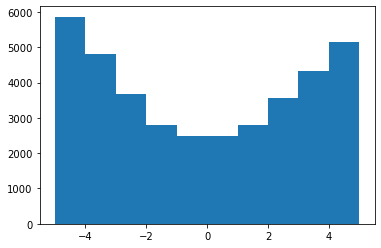

In [37]:
plt.hist(df22_good.b) # 已解决（问题出在reset_index上）

In [62]:
df12 = pd.concat([df11_good,df22_good])
df12

,index,source_id,ra,dec,redshift_qsoc,snrW1pm,snrW2pm,w1vega,w2vega,gp,...,dkap,dyab,djab,dhab,dkab,dw1vega,dw2vega,dw1ab,dw2ab,ebv
0,2,2740011460641576192,56.584367,48.772173,0.565801,54.000000,48.799999,15.406811,14.647540,23.539747,...,16.404118,19.269349,18.971625,18.618422,18.304118,15.314789,14.586192,18.013788,17.925192,0.761140
1,3,2740013011126020864,129.149247,-39.705601,0.792390,43.299999,48.900002,13.990549,12.862033,27.384218,...,15.140117,18.343350,18.080624,17.565423,17.040118,13.735789,12.692192,16.434788,16.031193,2.107201
3,5,2768962873110894208,346.720444,56.518488,1.611916,14.700000,14.900000,17.475535,16.113024,22.593422,...,18.123939,20.112150,19.976392,19.771544,20.023939,17.387090,16.054061,20.086090,19.393062,0.731554
4,8,2765244977620763776,288.610587,19.461234,1.103319,40.900002,37.400002,16.048502,15.075668,23.937421,...,17.476564,20.083239,20.070648,19.773905,19.376564,15.931150,14.997433,18.630150,18.336434,0.970654
7,14,2772071707879157632,16.532019,66.441485,1.937504,40.900002,39.900002,16.143607,14.986405,23.036452,...,16.940504,19.251205,19.108210,19.213589,18.840503,16.029392,14.910261,18.728392,18.249262,0.944708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67714,101574,2746640935937816192,229.674445,-53.414111,NaN,52.799999,75.000000,12.935685,11.385123,22.340122,...,14.319543,16.864777,16.648462,16.363265,16.219543,12.794277,11.290851,15.493276,14.629850,1.169627
67716,101577,2767326387491580160,255.625579,-49.320445,5.722703,37.299999,43.099998,16.368677,14.936786,24.159109,...,17.575905,18.992497,19.288966,19.361384,19.475904,16.200866,14.824911,18.899865,18.163911,1.388017
67719,101580,2738631333029907200,224.314387,-53.926004,NaN,56.400002,76.300003,15.306337,13.892891,24.998239,...,16.777994,19.459092,19.552445,19.056044,18.677993,15.187257,13.813505,17.886256,17.152505,0.984943
67720,101581,2772389088781683072,270.094121,-30.569698,0.265005,81.900002,128.699997,13.010307,11.920205,23.992310,...,14.523941,17.745340,17.543962,17.080850,16.423942,12.826024,11.797349,15.525023,15.136349,1.524263


In [63]:
df12.to_csv(outpath+'MockGPQNIR.csv', index=False)